## Experiment 1: base network selection

This experiment studies different options for the base GRN provided to CellOracle.

In [1]:
EXPERIMENT_NAME="baseNetwork_v1"

In [2]:
import warnings
warnings.filterwarnings('ignore')
import importlib
import os
import gc
import sys
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import celloracle as co

#      visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [3]:
# Deal with various file paths specific to this project
PROJECT_PATH = '/home/ekernf01/Desktop/jhu/research/projects/perturbation_prediction/cell_type_knowledge_transfer/'
os.chdir(PROJECT_PATH + "benchmarking/")
try:
    os.makedirs("results/" + EXPERIMENT_NAME)
except:
    pass

sys.path.append(os.path.expanduser(PROJECT_PATH + 'networks/load_networks'))
sys.path.append(os.path.expanduser(PROJECT_PATH + 'perturbations/load_perturbations')) 
sys.path.append(os.path.expanduser(PROJECT_PATH + 'benchmarking/evaluator')) 
import evaluator
import load_networks
import load_perturbations
importlib.reload(evaluator) 
importlib.reload(load_networks) 
importlib.reload(load_perturbations)
os.environ["GRN_PATH"]           = PROJECT_PATH + "networks/networks"
os.environ["PERTURBATION_PATH"]  = PROJECT_PATH + "perturbations/perturbations"

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2
Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2


In [4]:
X = evaluator.makeRandomNetwork(density = 1, TFs = ["foo", "bar", "baz"])
X.iloc[:, 2:] = np.array(X.iloc[:, 2:])   #undo sparse representation         
dict(X.iloc[:, 2:].apply(lambda x: x[x>0].index.values, axis=1))

{0: array(['foo', 'bar', 'baz'], dtype=object),
 1: array(['foo', 'bar', 'baz'], dtype=object),
 2: array(['foo', 'bar', 'baz'], dtype=object),
 3: array(['foo', 'bar', 'baz'], dtype=object),
 4: array(['foo', 'bar', 'baz'], dtype=object),
 5: array(['foo', 'bar', 'baz'], dtype=object),
 6: array(['foo', 'bar', 'baz'], dtype=object),
 7: array(['foo', 'bar', 'baz'], dtype=object),
 8: array(['foo', 'bar', 'baz'], dtype=object),
 9: array(['foo', 'bar', 'baz'], dtype=object),
 10: array(['foo', 'bar', 'baz'], dtype=object),
 11: array(['foo', 'bar', 'baz'], dtype=object),
 12: array(['foo', 'bar', 'baz'], dtype=object),
 13: array(['foo', 'bar', 'baz'], dtype=object),
 14: array(['foo', 'bar', 'baz'], dtype=object),
 15: array(['foo', 'bar', 'baz'], dtype=object),
 16: array(['foo', 'bar', 'baz'], dtype=object),
 17: array(['foo', 'bar', 'baz'], dtype=object),
 18: array(['foo', 'bar', 'baz'], dtype=object),
 19: array(['foo', 'bar', 'baz'], dtype=object),
 20: array(['foo', 'bar', 'baz

### Networks setup

This experiment aims to test a variety of published sparse regulatory network structures. 

In [5]:
networks = {
    'dense': evaluator.makeRandomNetwork(density = 1),
    'random0.1': evaluator.makeRandomNetwork(density = 0.1),
    'random0.01': evaluator.makeRandomNetwork(density = 0.01),
    'cellOracle': co.data.load_human_promoter_base_GRN()
}
gc.collect()

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2


0

In [6]:
pd.DataFrame({bn:sys.getsizeof(networks[bn])/1e6 for bn in networks}, index = ["memory"])

,dense,random0.1,random0.01,cellOracle
memory,2.636366,125.36657,14.906018,329.156543


In [7]:
for network in [
    # Networks used in GWAS-related projects
    'gtex_rna',
    'magnum_compendium_32',   
    'magnum_compendium_394', 
    'magnum_compendium_ppi',
    'humanbase',
    # Networks used in reprogramming-related and differentiation-related projects
    'cellnet_human_Hg1332',
    'cellnet_human_Hugene',
    'MARA_FANTOM4',
    'STRING',    
    'ANANSE_0.5',
    'ANANSE_tissue_0.5'
]:
    print("Loading " + network)
    if not network in networks:
        networks[network] = evaluator.networkEdgesToMatrix(load_networks.load_grn_all_subnetworks(network))
    gc.collect()
    
# One more network used in a reprogramming-related project
networks["mogrify"] = pd.concat([networks[n] for n in ['MARA_FANTOM4','STRING']])

network_sizes = pd.DataFrame({bn:evaluator.countMatrixEdges(networks[bn]) for bn in networks}, index = ["numEdges"])
network_sizes = network_sizes.T.reset_index().rename({"index":"network"}, axis = 1)
network_sizes

Loading gtex_rna
Loading magnum_compendium_32
Loading magnum_compendium_394
Loading magnum_compendium_ppi
Loading humanbase
Loading cellnet_human_Hg1332
Loading cellnet_human_Hugene
Loading MARA_FANTOM4
Loading STRING
Loading ANANSE_0.5
Loading ANANSE_tissue_0.5


,network,numEdges
0,dense,102313295.0
1,random0.1,10227517.0
2,random0.01,1022471.0
3,cellOracle,5134330.0
4,gtex_rna,1548622.0
5,magnum_compendium_32,3246008.0
6,magnum_compendium_394,3246008.0
7,magnum_compendium_ppi,246866.0
8,humanbase,26156969.0
9,cellnet_human_Hg1332,201422.0


### Memory consumption

This experiment has been a little problematic recently in terms of memory consumed. We can check on that briefly. 

In [8]:
pd.DataFrame({bn:sys.getsizeof(networks[bn])/1e6 for bn in networks}, index = ["memory"])

,dense,random0.1,random0.01,cellOracle,gtex_rna,magnum_compendium_32,magnum_compendium_394,magnum_compendium_ppi,humanbase,cellnet_human_Hg1332,cellnet_human_Hugene,MARA_FANTOM4,STRING,ANANSE_0.5,ANANSE_tissue_0.5,mogrify
memory,2.636366,125.36657,14.906018,329.156543,19.282986,40.140932,40.140932,4.29154,315.26506,3.123013,2.445973,0.317984,134.298736,29.477668,40.400131,810.060376


### Data setup

We use the Nakatake et al data. This experiment is on per-cluster versus shared regression models, so we run Leiden clustering at many different resolutions.

In [9]:
ko_lab_esc_data = sc.read_h5ad(os.environ["PERTURBATION_PATH"] + "/nakatake/" + "test.h5ad")

In [10]:
ko_lab_esc_data.obs.columns

Index(['perturbation', 'is_control', 'fraction_missing', 'leiden',
       'fake_cluster'],
      dtype='object')

In [12]:
allowedRegulators = set.union(*[set(networks[key].columns) for key in networks])
ko_lab_esc_data_train, ko_lab_esc_data_heldout, perturbationsToPredict = \
    evaluator.splitData(ko_lab_esc_data, allowedRegulators, minTestSetSize=250)

Example perturbations formatted as 
 (gene, expression after perturbation)
[('ALX3', 2.829177), ('ALX3', 3.583377), ('ALX4', 1.1726332), ('ALX4', 0.7964212), ('ANKRD22', 0.43029666)]
Test set size:
263
Training set size:
250


### Experimental metadata

In [13]:
n_networks = len(networks.keys())
experiments = pd.DataFrame({"network":[n for n in networks.keys()], 
                            "p":[1]*n_networks,
                            "threshold_number":[int(network_sizes['numEdges'].max())]*n_networks,
                            "pruning":["none"]*n_networks})
experiments["index"] = experiments.index
experiments.to_csv("results/" + EXPERIMENT_NAME + "/networkExperiments.csv")
experiments

,network,p,threshold_number,pruning,index
0,dense,1,102313295,none,0
1,random0.1,1,102313295,none,1
2,random0.01,1,102313295,none,2
3,cellOracle,1,102313295,none,3
4,gtex_rna,1,102313295,none,4
5,magnum_compendium_32,1,102313295,none,5
6,magnum_compendium_394,1,102313295,none,6
7,magnum_compendium_ppi,1,102313295,none,7
8,humanbase,1,102313295,none,8
9,cellnet_human_Hg1332,1,102313295,none,9


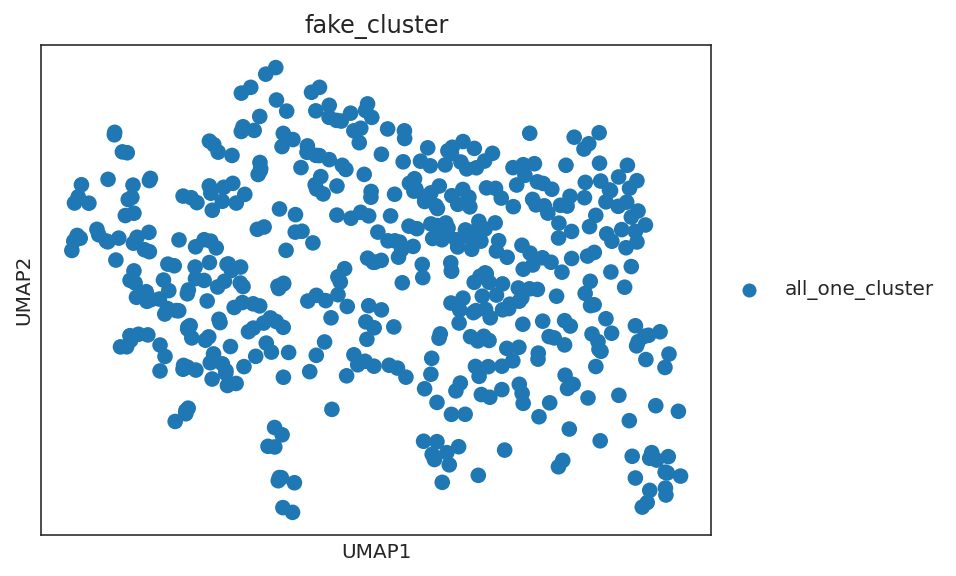

Working on results/baseNetwork_v1/0.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/2407 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2407 genes
Predicting ZNF74
ALX3 ALX3 ALX4 ALX4 ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AR AR ARNT2 ARNT2 ASH2L 
Prediction failed for ASH2L with error Gene ASH2L is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASH2L 
Prediction failed for ASH2L with error Gene ASH2L is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ATF2 ATF2 ATF3 ATF3 BACH1 BACH1 BARHL2 BARHL2 BARX2 BARX2 BCL6 BCL6 BHLHE40 BHLHE40 BMP4 BMP4 BRF2 BRF2 CDX2 CDX2 CDX2 CDYL 
Prediction failed for CDYL with error Gene CDYL is not included in the bas

SALL4 SALL4 SAP30 
Prediction failed for SAP30 with error Gene SAP30 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SETDB1 SETDB1 SIN3A SIN3A SIX5 SIX5 SMAD1 SMAD1 SMAD2 SMAD2 SMAD4 SMAD4 SMAD5 SMC3 SMC3 SNAI1 SNAI1 SNAI2 SNAI2 SOX14 SOX14 SOX15 SOX15 SOX17 SOX17 SOX2 SOX2 SOX7 SOX7 SPIC SPIC SPIC STAG1 STAG1 STAT3 STAT3 STAT4 STAT4 STAT5A STAT5A STRA8 
Prediction failed for STRA8 with error Gene STRA8 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
STRA8 
Prediction failed for STRA8 with error Gene STRA8 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TBX2 TBX2 TBX4 TBX4 TBX5 TBX5 TCF12 TCF12 TCF4 TCF4 TCF7L2 TCF7L2 TEAD4 TEAD4 TFAP2A TFAP2A TFAP2B TFAP2B TFCP2L1 TFCP2L1 TFE3 TFE3 TGIF1 TGIF1 TGM2 
Prediction failed for TGM2 with error Gene TGM2 is not included in the base GRN; It is no

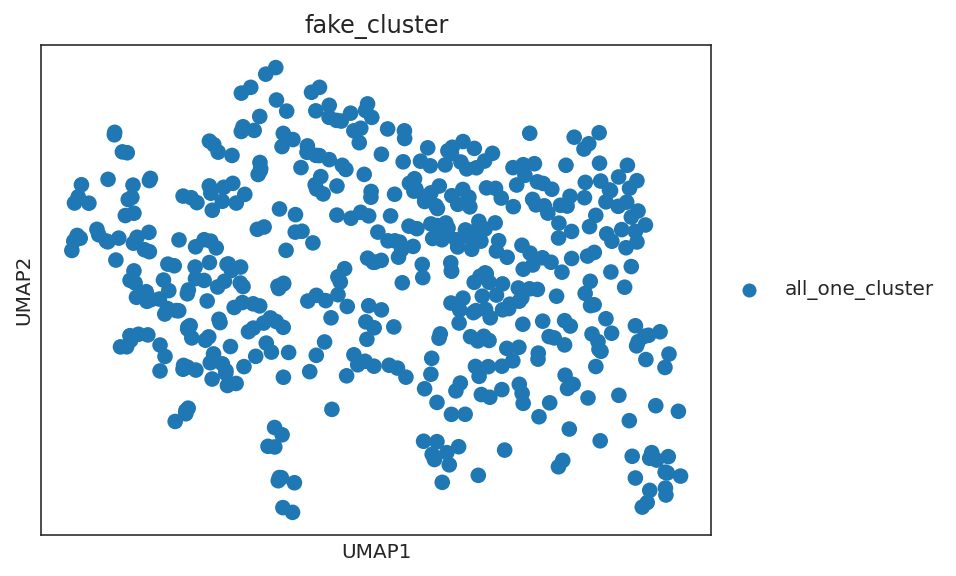

Working on results/baseNetwork_v1/1.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/2407 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2407 genes
Predicting ZNF74
ALX3 ALX3 ALX4 ALX4 ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AR AR ARNT2 ARNT2 ASH2L 
Prediction failed for ASH2L with error Gene ASH2L is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASH2L 
Prediction failed for ASH2L with error Gene ASH2L is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ATF2 ATF2 ATF3 ATF3 BACH1 BACH1 BARHL2 BARHL2 BARX2 BARX2 BCL6 BCL6 BHLHE40 BHLHE40 BMP4 BMP4 BRF2 BRF2 CDX2 CDX2 CDX2 CDYL 
Prediction failed for CDYL with error Gene CDYL is not included in the bas

SALL4 SALL4 SAP30 
Prediction failed for SAP30 with error Gene SAP30 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SETDB1 SETDB1 SIN3A SIN3A SIX5 SIX5 SMAD1 SMAD1 SMAD2 SMAD2 SMAD4 SMAD4 SMAD5 SMC3 SMC3 SNAI1 SNAI1 SNAI2 SNAI2 SOX14 SOX14 SOX15 SOX15 SOX17 SOX17 SOX2 SOX2 SOX7 SOX7 SPIC SPIC SPIC STAG1 STAG1 STAT3 STAT3 STAT4 STAT4 STAT5A STAT5A STRA8 
Prediction failed for STRA8 with error Gene STRA8 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
STRA8 
Prediction failed for STRA8 with error Gene STRA8 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TBX2 TBX2 TBX4 TBX4 TBX5 TBX5 TCF12 TCF12 TCF4 TCF4 TCF7L2 TCF7L2 TEAD4 TEAD4 TFAP2A TFAP2A TFAP2B TFAP2B TFCP2L1 TFCP2L1 TFE3 TFE3 TGIF1 TGIF1 TGM2 
Prediction failed for TGM2 with error Gene TGM2 is not included in the base GRN; It is no

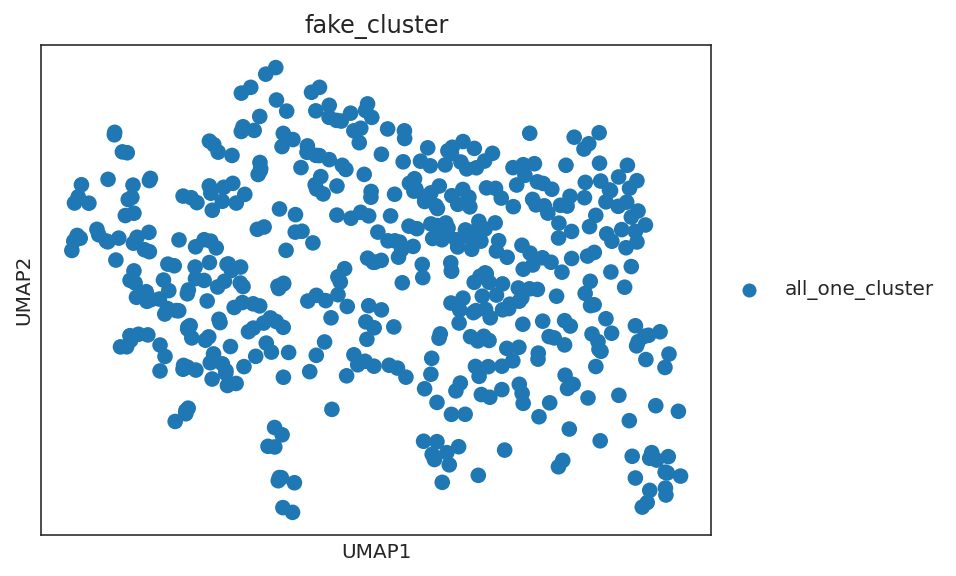

Working on results/baseNetwork_v1/2.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/2407 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2404 genes
Predicting ZNF74
ALX3 ALX3 ALX4 ALX4 ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AR AR ARNT2 ARNT2 ASH2L 
Prediction failed for ASH2L with error Gene ASH2L is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASH2L 
Prediction failed for ASH2L with error Gene ASH2L is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ATF2 ATF2 ATF3 ATF3 BACH1 BACH1 BARHL2 BARHL2 BARX2 BARX2 BCL6 BCL6 BHLHE40 BHLHE40 BMP4 BMP4 BRF2 BRF2 CDX2 CDX2 CDX2 CDYL 
Prediction failed for CDYL with error Gene CDYL is not included in the bas

SALL4 SALL4 SAP30 
Prediction failed for SAP30 with error Gene SAP30 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SETDB1 SETDB1 SIN3A SIN3A SIX5 SIX5 SMAD1 SMAD1 SMAD2 SMAD2 SMAD4 SMAD4 SMAD5 SMC3 SMC3 SNAI1 SNAI1 SNAI2 SNAI2 SOX14 SOX14 SOX15 SOX15 SOX17 SOX17 SOX2 SOX2 SOX7 SOX7 SPIC SPIC SPIC STAG1 STAG1 STAT3 STAT3 STAT4 STAT4 STAT5A STAT5A STRA8 
Prediction failed for STRA8 with error Gene STRA8 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
STRA8 
Prediction failed for STRA8 with error Gene STRA8 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TBX2 TBX2 TBX4 TBX4 TBX5 TBX5 TCF12 TCF12 TCF4 TCF4 TCF7L2 TCF7L2 TEAD4 TEAD4 TFAP2A TFAP2A TFAP2B TFAP2B TFCP2L1 TFCP2L1 TFE3 TFE3 TGIF1 TGIF1 TGM2 
Prediction failed for TGM2 with error Gene TGM2 is not included in the base GRN; It is no

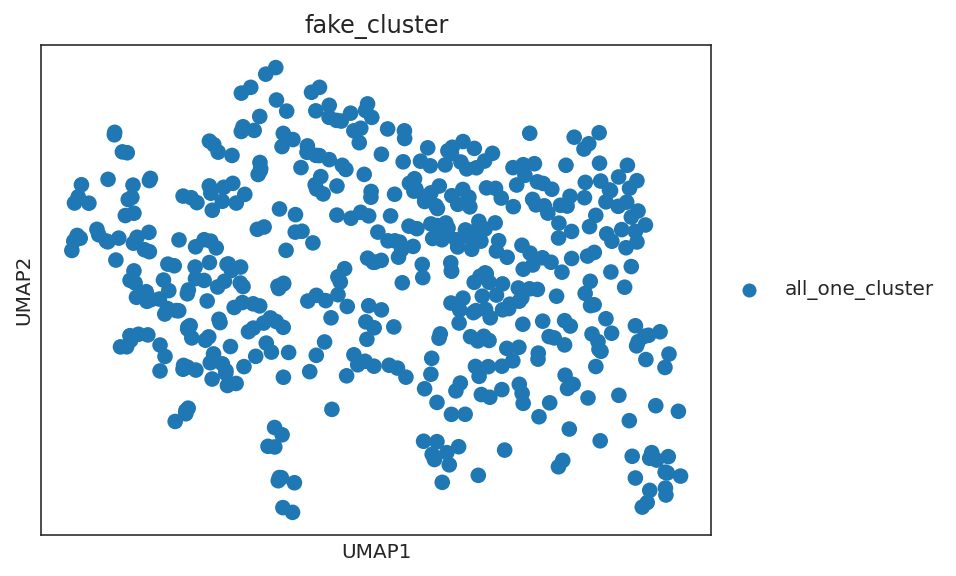

Working on results/baseNetwork_v1/3.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/2407 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2406 genes
Predicting ZNF74
ALX3 ALX3 ALX4 ALX4 ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AR AR ARNT2 ARNT2 ASH2L 
Prediction failed for ASH2L with error Gene ASH2L is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASH2L 
Prediction failed for ASH2L with error Gene ASH2L is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ATF2 ATF2 ATF3 ATF3 BACH1 BACH1 BARHL2 BARHL2 BARX2 BARX2 BCL6 BCL6 BHLHE40 BHLHE40 BMP4 
Prediction failed for BMP4 with error Gene BMP4 is not included in the base GRN; It is not TF or TF motif inf

HOXB4 HOXB4 HOXC9 HOXC9 HOXD10 HOXD10 HOXD13 HOXD13 HSF1 HSF1 ID1 ID1 ID3 IKZF1 IKZF1 IRF1 IRF1 IRF3 IRF3 IRF5 IRF5 JARID2 
Prediction failed for JARID2 with error Gene JARID2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
JARID2 
Prediction failed for JARID2 with error Gene JARID2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
JUN JUN KAT8 
Prediction failed for KAT8 with error Gene KAT8 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KAT8 
Prediction failed for KAT8 with error Gene KAT8 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KDM1A 
Prediction failed for KDM1A with error Gene KDM1A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KDM1A 
Predictio

RUNX1 RUNX1 RUNX3 RUNX3 RUVBL2 
Prediction failed for RUVBL2 with error Gene RUVBL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
RUVBL2 
Prediction failed for RUVBL2 with error Gene RUVBL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SALL4 SALL4 SAP30 
Prediction failed for SAP30 with error Gene SAP30 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SETDB1 SETDB1 SIN3A SIN3A SIX5 SIX5 SMAD1 SMAD1 SMAD2 SMAD2 SMAD4 SMAD4 SMAD5 
Prediction failed for SMAD5 with error Gene SMAD5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SMC3 SMC3 SNAI1 SNAI1 SNAI2 SNAI2 SOX14 SOX14 SOX15 SOX15 SOX17 SOX17 SOX2 SOX2 SOX7 SOX7 SPIC SPIC SPIC STAG1 
Prediction failed for STAG1 with error Gene STAG1 is not included in the base GRN; It 

EMX2 EMX2 ETV4 ETV4 FGR 
Prediction failed for FGR with error Gene FGR is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FGR 
Prediction failed for FGR with error Gene FGR is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXE1 FOXE1 GTF3C5 
Prediction failed for GTF3C5 with error Gene GTF3C5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GTF3C5 
Prediction failed for GTF3C5 with error Gene GTF3C5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HMGA1 HMGA1 HNRNPD 
Prediction failed for HNRNPD with error Gene HNRNPD is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HNRNPD 
Prediction failed for HNRNPD with error Gene HNRNPD is not included in the base GRN; It is 

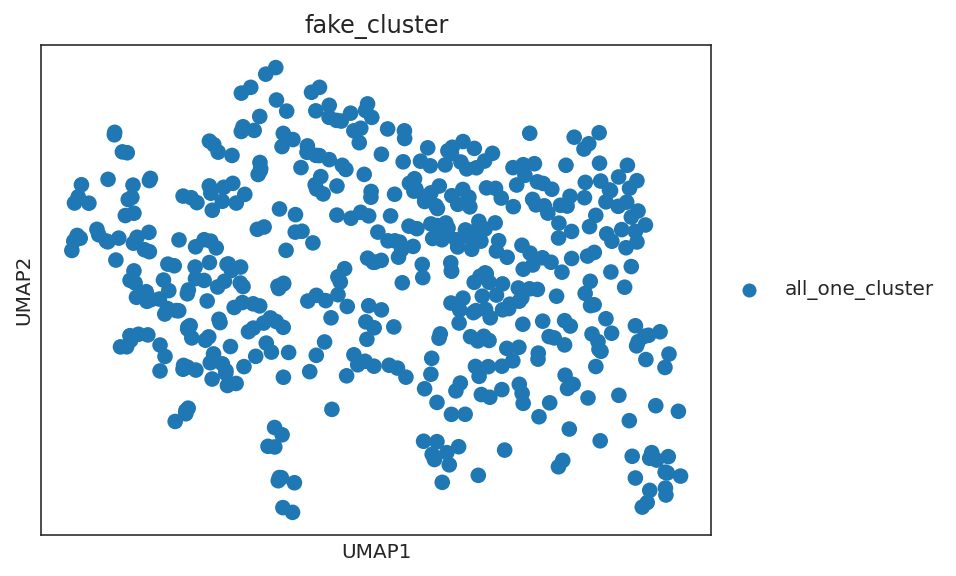

Working on results/baseNetwork_v1/4.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/1719 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 1687 genes
Predicting ZNF74
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 ALX4 ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AR AR ARNT2 ARNT2 ASH2L ASH2L ATF2 ATF2 ATF3 ATF3 BACH1 BACH1 BARHL2 
Prediction failed for BARHL2 with error Gene BARHL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulati

FOXM1 FOXM1 FOXS1 FOXS1 GABPA GABPA GATA1 GATA1 GATA2 GATA2 GBX2 
Prediction failed for GBX2 with error Gene GBX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GBX2 
Prediction failed for GBX2 with error Gene GBX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GLI1 GLI1 GRHL2 GRHL2 GSC 
Prediction failed for GSC with error Gene GSC is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GSC 
Prediction failed for GSC with error Gene GSC is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GTF2B 
Prediction failed for GTF2B with error Gene GTF2B is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GTF2B 
Prediction failed for GTF2B with error Gene GTF2B is not included in 

NEUROD1 NEUROD1 NEUROD4 
Prediction failed for NEUROD4 with error Gene NEUROD4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NEUROD4 
Prediction failed for NEUROD4 with error Gene NEUROD4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NEUROD6 
Prediction failed for NEUROD6 with error Gene NEUROD6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NEUROD6 
Prediction failed for NEUROD6 with error Gene NEUROD6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NEUROG1 
Prediction failed for NEUROG1 with error Gene NEUROG1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NEUROG1 
Prediction failed for NEUROG1 with error Gene NEUROG1 is not included in the base GRN

SAP30 SETDB1 
Prediction failed for SETDB1 with error Gene SETDB1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SETDB1 
Prediction failed for SETDB1 with error Gene SETDB1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SIN3A SIN3A SIX5 SIX5 SMAD1 SMAD1 SMAD2 
Prediction failed for SMAD2 with error Gene SMAD2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SMAD2 
Prediction failed for SMAD2 with error Gene SMAD2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SMAD4 
Prediction failed for SMAD4 with error Gene SMAD4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SMAD4 
Prediction failed for SMAD4 with error Gene SMAD4 is not included in the base GRN; It i

ZNF281 ZNF281 ZNF426 
Prediction failed for ZNF426 with error Gene ZNF426 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZNF426 
Prediction failed for ZNF426 with error Gene ZNF426 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZNF646 ZNF646 ZNF706 
Prediction failed for ZNF706 with error Gene ZNF706 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZNF706 
Prediction failed for ZNF706 with error Gene ZNF706 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZNF713 
Prediction failed for ZNF713 with error Gene ZNF713 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZNF713 
Prediction failed for ZNF713 with error Gene ZNF713 is not included in the base GRN; It i

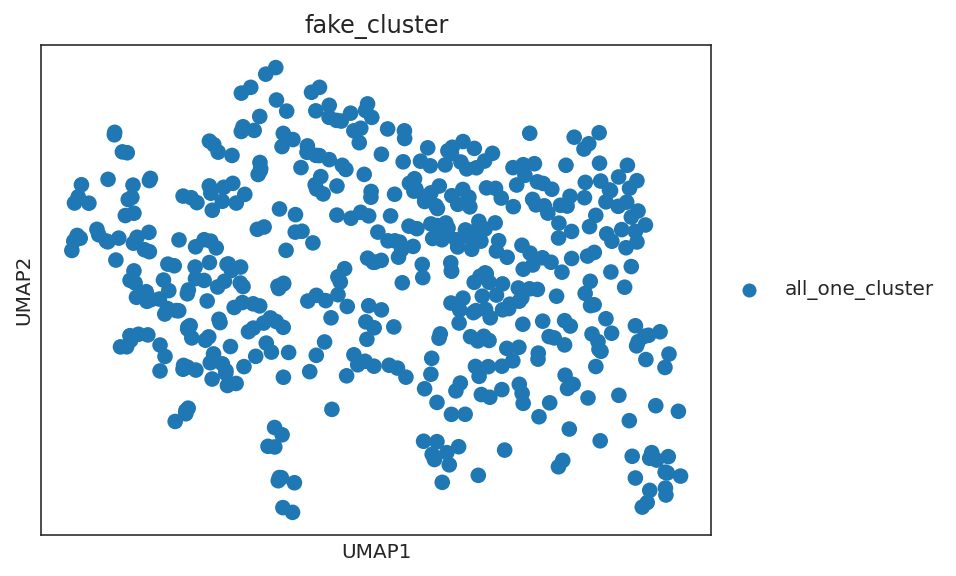

Working on results/baseNetwork_v1/5.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/2284 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2284 genes
Predicting ZNF74
ALX3 ALX3 ALX4 ALX4 ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AR AR ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASH2L 
Prediction failed for ASH2L with error Gene ASH2L is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASH2L 
Prediction failed for ASH2L with

GSC GSC GTF2B 
Prediction failed for GTF2B with error Gene GTF2B is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GTF2B 
Prediction failed for GTF2B with error Gene GTF2B is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GTF2F1 
Prediction failed for GTF2F1 with error Gene GTF2F1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GTF2F1 
Prediction failed for GTF2F1 with error Gene GTF2F1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
H2AFZ 
Prediction failed for H2AFZ with error Gene H2AFZ is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
H2AFZ 
Prediction failed for H2AFZ with error Gene H2AFZ is not included in the base GRN; It is not TF or TF motif information

MEF2A MEF2A MEIS1 MEIS1 MEIS2 MEIS2 MKRN1 
Prediction failed for MKRN1 with error Gene MKRN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MKRN1 
Prediction failed for MKRN1 with error Gene MKRN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MSC 
Prediction failed for MSC with error Gene MSC is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MSC 
Prediction failed for MSC with error Gene MSC is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MSGN1 
Prediction failed for MSGN1 with error Gene MSGN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MSGN1 
Prediction failed for MSGN1 with error Gene MSGN1 is not included in the base GRN; It is not TF or TF motif i

REST REST RFX2 RFX2 RNF2 
Prediction failed for RNF2 with error Gene RNF2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
RNF2 
Prediction failed for RNF2 with error Gene RNF2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
RUNX1 RUNX1 RUNX3 RUNX3 RUVBL2 
Prediction failed for RUVBL2 with error Gene RUVBL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
RUVBL2 
Prediction failed for RUVBL2 with error Gene RUVBL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SALL4 
Prediction failed for SALL4 with error Gene SALL4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SALL4 
Prediction failed for SALL4 with error Gene SALL4 is not included in the base GRN; It is 

ZBTB33 ZBTB33 ZBTB45 
Prediction failed for ZBTB45 with error Gene ZBTB45 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZBTB45 
Prediction failed for ZBTB45 with error Gene ZBTB45 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZBTB7A ZFAND3 
Prediction failed for ZFAND3 with error Gene ZFAND3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZFAND3 
Prediction failed for ZFAND3 with error Gene ZFAND3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZIC1 ZIC1 ZKSCAN1 
Prediction failed for ZKSCAN1 with error Gene ZKSCAN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZKSCAN1 
Prediction failed for ZKSCAN1 with error Gene ZKSCAN1 is not included in the base 

THRA THRA TNF 
Prediction failed for TNF with error Gene TNF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TNF 
Prediction failed for TNF with error Gene TNF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZNF384 ZNF384 ZNF384 ZNF384 ZNF480 
Prediction failed for ZNF480 with error Gene ZNF480 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZNF480 
Prediction failed for ZNF480 with error Gene ZNF480 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZNF74 
Prediction failed for ZNF74 with error Gene ZNF74 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZNF74 
Prediction failed for ZNF74 with error Gene ZNF74 is not included in the base GRN; It is not TF or TF

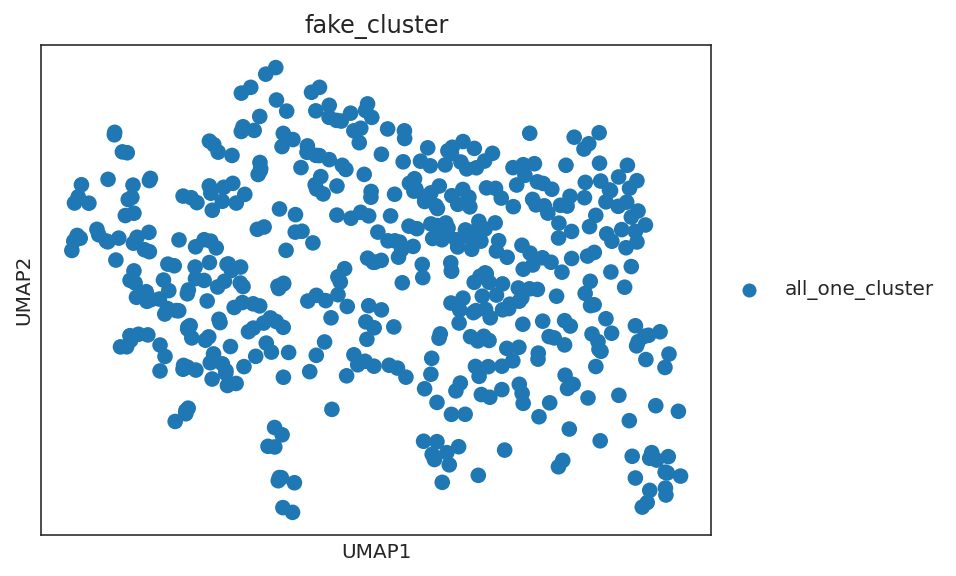

Working on results/baseNetwork_v1/6.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/2284 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2284 genes
Predicting ZNF74
ALX3 ALX3 ALX4 ALX4 ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AR AR ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASH2L 
Prediction failed for ASH2L with error Gene ASH2L is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASH2L 
Prediction failed for ASH2L with

GSC GSC GTF2B 
Prediction failed for GTF2B with error Gene GTF2B is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GTF2B 
Prediction failed for GTF2B with error Gene GTF2B is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GTF2F1 
Prediction failed for GTF2F1 with error Gene GTF2F1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GTF2F1 
Prediction failed for GTF2F1 with error Gene GTF2F1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
H2AFZ 
Prediction failed for H2AFZ with error Gene H2AFZ is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
H2AFZ 
Prediction failed for H2AFZ with error Gene H2AFZ is not included in the base GRN; It is not TF or TF motif information

MEF2A MEF2A MEIS1 MEIS1 MEIS2 MEIS2 MKRN1 
Prediction failed for MKRN1 with error Gene MKRN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MKRN1 
Prediction failed for MKRN1 with error Gene MKRN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MSC 
Prediction failed for MSC with error Gene MSC is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MSC 
Prediction failed for MSC with error Gene MSC is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MSGN1 
Prediction failed for MSGN1 with error Gene MSGN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MSGN1 
Prediction failed for MSGN1 with error Gene MSGN1 is not included in the base GRN; It is not TF or TF motif i

REST REST RFX2 RFX2 RNF2 
Prediction failed for RNF2 with error Gene RNF2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
RNF2 
Prediction failed for RNF2 with error Gene RNF2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
RUNX1 RUNX1 RUNX3 RUNX3 RUVBL2 
Prediction failed for RUVBL2 with error Gene RUVBL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
RUVBL2 
Prediction failed for RUVBL2 with error Gene RUVBL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SALL4 
Prediction failed for SALL4 with error Gene SALL4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SALL4 
Prediction failed for SALL4 with error Gene SALL4 is not included in the base GRN; It is 

ZBTB33 ZBTB33 ZBTB45 
Prediction failed for ZBTB45 with error Gene ZBTB45 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZBTB45 
Prediction failed for ZBTB45 with error Gene ZBTB45 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZBTB7A ZFAND3 
Prediction failed for ZFAND3 with error Gene ZFAND3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZFAND3 
Prediction failed for ZFAND3 with error Gene ZFAND3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZIC1 ZIC1 ZKSCAN1 
Prediction failed for ZKSCAN1 with error Gene ZKSCAN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZKSCAN1 
Prediction failed for ZKSCAN1 with error Gene ZKSCAN1 is not included in the base 

THRA THRA TNF 
Prediction failed for TNF with error Gene TNF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TNF 
Prediction failed for TNF with error Gene TNF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZNF384 ZNF384 ZNF384 ZNF384 ZNF480 
Prediction failed for ZNF480 with error Gene ZNF480 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZNF480 
Prediction failed for ZNF480 with error Gene ZNF480 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZNF74 
Prediction failed for ZNF74 with error Gene ZNF74 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZNF74 
Prediction failed for ZNF74 with error Gene ZNF74 is not included in the base GRN; It is not TF or TF

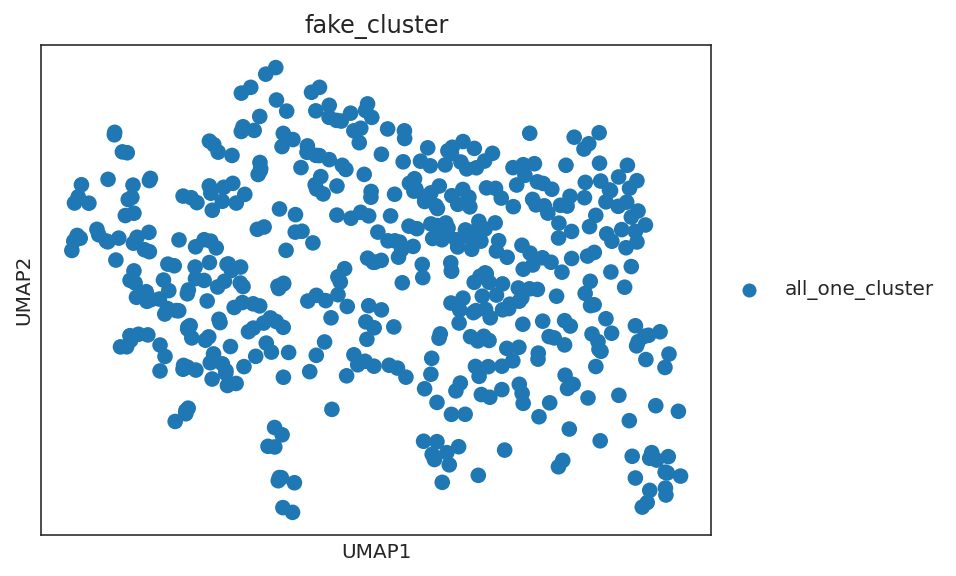

Working on results/baseNetwork_v1/7.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/2241 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2119 genes
Predicting ZNF74
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not availab

NEUROD1 NEUROD1 NEUROD4 
Prediction failed for NEUROD4 with error Gene NEUROD4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NEUROD4 
Prediction failed for NEUROD4 with error Gene NEUROD4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NEUROD6 
Prediction failed for NEUROD6 with error Gene NEUROD6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NEUROD6 
Prediction failed for NEUROD6 with error Gene NEUROD6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NEUROG1 NEUROG1 NEUROG2 
Prediction failed for NEUROG2 with error Gene NEUROG2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NEUROG2 
Prediction failed for NEUROG2 with error Gene NEUROG2 is not included

ZBTB33 ZBTB33 ZBTB45 
Prediction failed for ZBTB45 with error Gene ZBTB45 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
ZBTB45 
Prediction failed for ZBTB45 with error Gene ZBTB45 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
ZBTB7A ZFAND3 
Prediction failed for ZFAND3 with error Gene ZFAND3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZFAND3 
Prediction failed for ZFAND3 with error Gene ZFAND3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZIC1 ZIC1 ZKSCAN1 ZKSCAN1 ZNF263 
Prediction failed for ZNF263 with error Gene ZNF263 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
ZNF263 
Prediction failed for ZNF263 with error Gene ZNF263 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
ZNF280B 
Prediction failed for 

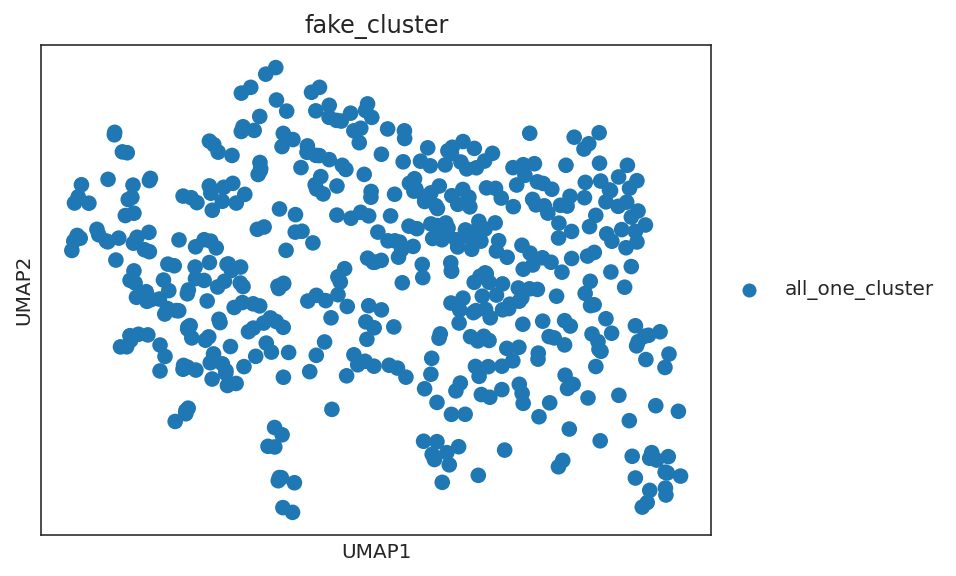

Working on results/baseNetwork_v1/8.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/2403 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2385 genes
Predicting ZNF74
ALX3 ALX3 ALX4 ALX4 ANKRD22 ANKRD22 AR AR ARNT2 ARNT2 ASH2L ASH2L ATF2 ATF2 ATF3 ATF3 BACH1 BACH1 BARHL2 BARHL2 BARX2 BARX2 BCL6 BCL6 BHLHE40 BHLHE40 BMP4 BMP4 BRF2 BRF2 CDX2 CDX2 CDX2 CDYL CDYL CEBPB CEBPB CHD4 CHD4 CREB3 CREB3 CTCF DEDD2 DEDD2 DLX2 DLX2 DLX4 DLX4 DMRT1 DMRT1 DMRTC2 DMRTC2 DNMT3L DNMT3L E2F4 E2F4 E2F6 E2F6 EED EED ELF2 ELF2 ELF4 ELF5 ELF5 ELK1 ELK1 ELL2 ELL2 ELOA ELOA ESRRB ESRRB ESRRG ESRRG ESX1 
Prediction failed for ESX1 with error Gene ESX1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
ESX1 
Prediction failed for ESX1 with error Gene ESX1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
ETS1 ETS1 ETS2 ETS2 ETV5 ETV5 FBXO15 FBXO15 FIGLA 
Prediction failed for FIGLA with error Gene FIGLA does not have enough regulatory connection in the GRNs. Cannot perform simulation.
FIGLA 
Prediction failed for FIGLA with error Gene FIGLA does not 

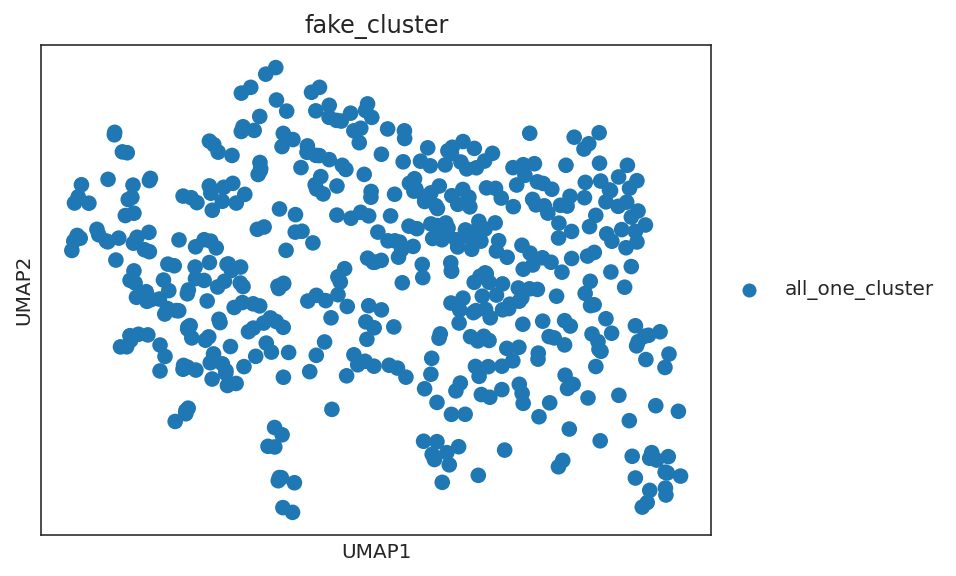

Working on results/baseNetwork_v1/9.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/1429 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 1261 genes
Predicting ZNF74
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 ANKRD22 AR 
Prediction failed for AR with error Gene AR is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AR 
Prediction failed for AR with error Gene AR is not included in the base GRN; I

FOXH1 FOXH1 FOXM1 FOXM1 FOXS1 FOXS1 GABPA 
Prediction failed for GABPA with error Gene GABPA is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GABPA 
Prediction failed for GABPA with error Gene GABPA is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GATA1 GATA1 GATA2 GATA2 GBX2 
Prediction failed for GBX2 with error Gene GBX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GBX2 
Prediction failed for GBX2 with error Gene GBX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GLI1 
Prediction failed for GLI1 with error Gene GLI1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GLI1 
Prediction failed for GLI1 with error Gene GLI1 is not included in the base GRN; It

MEIS1 MEIS1 MEIS2 MEIS2 MKRN1 
Prediction failed for MKRN1 with error Gene MKRN1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
MKRN1 
Prediction failed for MKRN1 with error Gene MKRN1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
MSC MSC MSGN1 
Prediction failed for MSGN1 with error Gene MSGN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MSGN1 
Prediction failed for MSGN1 with error Gene MSGN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MSX2 MSX2 MXI1 MXI1 MYB MYB MYBL2 MYBL2 MYF5 MYF5 MYF6 MYF6 NELFA 
Prediction failed for NELFA with error Gene NELFA is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NELFA 
Prediction failed for NELFA with error Gene NELFA is not included in the base GRN; It is not TF or TF mot

RFX2 RFX2 RNF2 
Prediction failed for RNF2 with error Gene RNF2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
RNF2 
Prediction failed for RNF2 with error Gene RNF2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
RUNX1 RUNX1 RUNX3 RUNX3 RUVBL2 RUVBL2 SALL4 SALL4 SAP30 SETDB1 SETDB1 SIN3A 
Prediction failed for SIN3A with error Gene SIN3A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SIN3A 
Prediction failed for SIN3A with error Gene SIN3A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SIX5 
Prediction failed for SIX5 with error Gene SIX5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SIX5 
Prediction failed for SIX5 with error Gene SIX5 is not included

ZIC1 ZIC1 ZKSCAN1 
Prediction failed for ZKSCAN1 with error Gene ZKSCAN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZKSCAN1 
Prediction failed for ZKSCAN1 with error Gene ZKSCAN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZNF263 
Prediction failed for ZNF263 with error Gene ZNF263 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZNF263 
Prediction failed for ZNF263 with error Gene ZNF263 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZNF280B 
Prediction failed for ZNF280B with error Gene ZNF280B is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZNF280B 
Prediction failed for ZNF280B with error Gene ZNF280B is not included in the base GRN; It is not 

ZNF74 ZNF74 

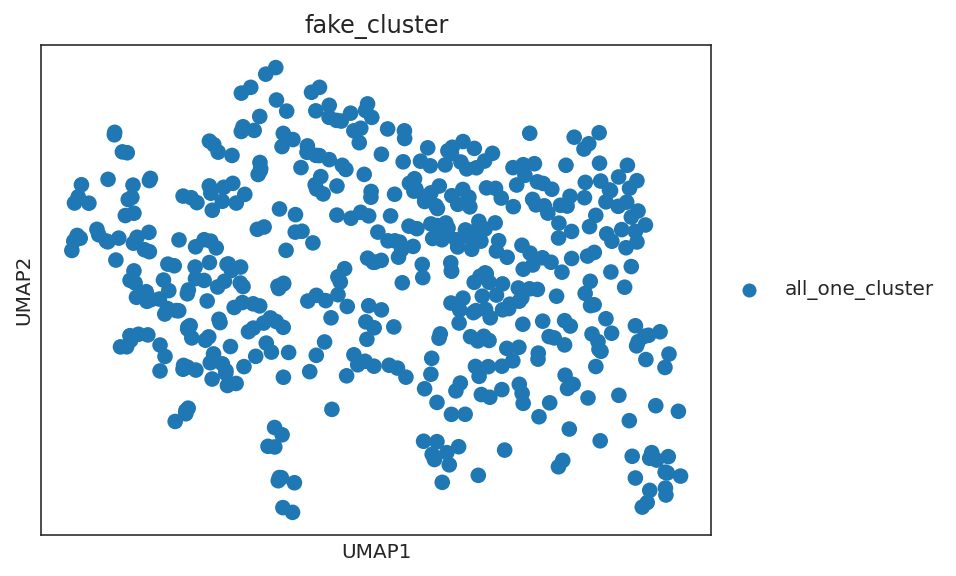

Working on results/baseNetwork_v1/10.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/1290 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 1149 genes
Predicting ZNF74
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 ANKRD22 AR 
Prediction failed for AR with error Gene AR is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AR 
Prediction failed for AR with error Gene AR is not included in the base GRN; I

FLI1 FLI1 FOS FOS FOSL1 FOSL1 FOXD1 FOXD1 FOXD4L3 
Prediction failed for FOXD4L3 with error Gene FOXD4L3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXD4L3 
Prediction failed for FOXD4L3 with error Gene FOXD4L3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXE3 
Prediction failed for FOXE3 with error Gene FOXE3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXE3 
Prediction failed for FOXE3 with error Gene FOXE3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXH1 FOXH1 FOXM1 FOXM1 FOXS1 FOXS1 GABPA 
Prediction failed for GABPA with error Gene GABPA is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GABPA 
Prediction failed for GABPA with error Gene

LMO1 LMO1 MAB21L2 
Prediction failed for MAB21L2 with error Gene MAB21L2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MAB21L2 
Prediction failed for MAB21L2 with error Gene MAB21L2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MEF2A 
Prediction failed for MEF2A with error Gene MEF2A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MEF2A 
Prediction failed for MEF2A with error Gene MEF2A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MEIS1 MEIS1 MEIS2 MEIS2 MKRN1 
Prediction failed for MKRN1 with error Gene MKRN1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
MKRN1 
Prediction failed for MKRN1 with error Gene MKRN1 does not have enough regulatory connection in the GRNs. Cannot perfor

POU2AF1 POU2AF1 POU2F2 POU2F2 POU4F1 
Prediction failed for POU4F1 with error Gene POU4F1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
POU4F1 
Prediction failed for POU4F1 with error Gene POU4F1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
POU5F1 
Prediction failed for POU5F1 with error Gene POU5F1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
POU5F1 
Prediction failed for POU5F1 with error Gene POU5F1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
POU5F1 
Prediction failed for POU5F1 with error Gene POU5F1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PPARGC1A 
Prediction failed for PPARGC1A with error Gene PPARGC1A is not included in the base GRN; It is not TF or TF motif information is not available. Canno

TGM2 TGM2 THAP1 
Prediction failed for THAP1 with error Gene THAP1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
THAP1 
Prediction failed for THAP1 with error Gene THAP1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
THAP11 
Prediction failed for THAP11 with error Gene THAP11 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
THAP11 
Prediction failed for THAP11 with error Gene THAP11 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
THAP3 
Prediction failed for THAP3 with error Gene THAP3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
THAP3 
Prediction failed for THAP3 with error Gene THAP3 is not included in the base GRN; It is not TF or TF motif informati

CXXC5 CXXC5 EMX2 EMX2 ETV4 ETV4 FGR FGR FOXE1 
Prediction failed for FOXE1 with error Gene FOXE1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXE1 
Prediction failed for FOXE1 with error Gene FOXE1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GTF3C5 
Prediction failed for GTF3C5 with error Gene GTF3C5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GTF3C5 
Prediction failed for GTF3C5 with error Gene GTF3C5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HMGA1 HMGA1 HNRNPD 
Prediction failed for HNRNPD with error Gene HNRNPD is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HNRNPD 
Prediction failed for HNRNPD with error Gene HNRNPD is not included in 

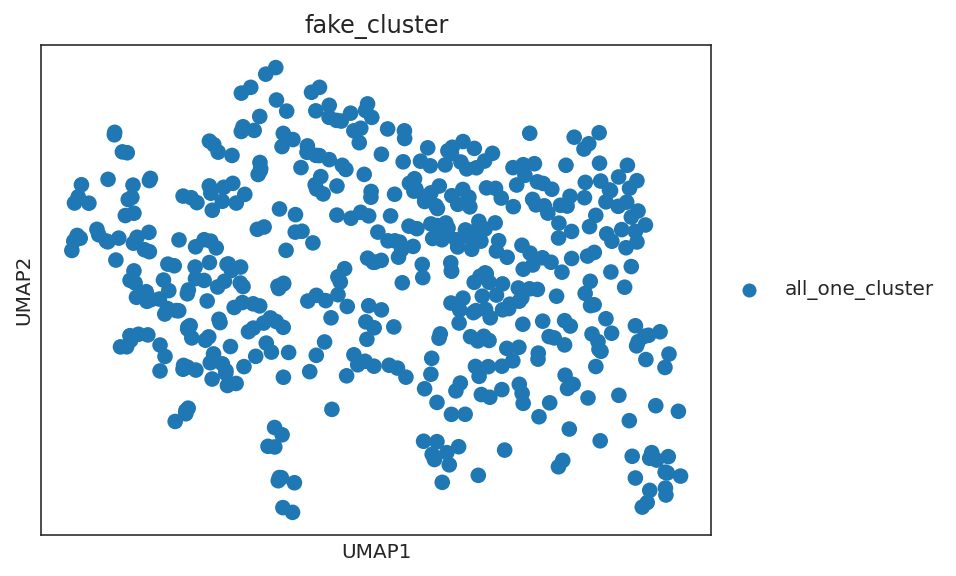

Working on results/baseNetwork_v1/11.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.
Total number of TF was 49. Although we can go to the GRN calculation with this data, but the TF number is small.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/402 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 294 genes
Predicting ZNF74
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 ALX4 ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AR 
Prediction failed for AR with error Gene AR is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AR 
Prediction failed for AR with error Gene AR is not included in the 

HNF1A HOPX 
Prediction failed for HOPX with error Gene HOPX is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOPX 
Prediction failed for HOPX with error Gene HOPX is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXA10 
Prediction failed for HOXA10 with error Gene HOXA10 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXA10 
Prediction failed for HOXA10 with error Gene HOXA10 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXA2 
Prediction failed for HOXA2 with error Gene HOXA2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXA2 
Prediction failed for HOXA2 with error Gene HOXA2 is not included in the base GRN; It is not TF or TF motif information is not 

MYB MYB MYBL2 MYBL2 MYF5 
Prediction failed for MYF5 with error Gene MYF5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MYF5 
Prediction failed for MYF5 with error Gene MYF5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MYF6 
Prediction failed for MYF6 with error Gene MYF6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MYF6 
Prediction failed for MYF6 with error Gene MYF6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NELFA 
Prediction failed for NELFA with error Gene NELFA is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NELFA 
Prediction failed for NELFA with error Gene NELFA is not included in the base GRN; It is not TF or TF motif information is no

PAX2 PAX2 PAX5 PAX5 PAX6 
Prediction failed for PAX6 with error Gene PAX6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PAX6 
Prediction failed for PAX6 with error Gene PAX6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PAX8 
Prediction failed for PAX8 with error Gene PAX8 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PAX8 
Prediction failed for PAX8 with error Gene PAX8 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PDX1 PDX1 PHF8 
Prediction failed for PHF8 with error Gene PHF8 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PHF8 
Prediction failed for PHF8 with error Gene PHF8 is not included in the base GRN; It is not TF or TF motif information i

SOX17 SOX17 SOX2 SOX2 SOX7 
Prediction failed for SOX7 with error Gene SOX7 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SOX7 
Prediction failed for SOX7 with error Gene SOX7 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SPIC 
Prediction failed for SPIC with error Gene SPIC is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SPIC 
Prediction failed for SPIC with error Gene SPIC is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SPIC 
Prediction failed for SPIC with error Gene SPIC is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
STAG1 
Prediction failed for STAG1 with error Gene STAG1 is not included in the base GRN; It is not TF or TF motif information is not

ALX1 ALX1 ATF4 ATF4 CBFB 
Prediction failed for CBFB with error Gene CBFB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
CHD5 
Prediction failed for CHD5 with error Gene CHD5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
CHD5 
Prediction failed for CHD5 with error Gene CHD5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
CITED1 
Prediction failed for CITED1 with error Gene CITED1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
CITED1 
Prediction failed for CITED1 with error Gene CITED1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
CTBP1 
Prediction failed for CTBP1 with error Gene CTBP1 is not included in the base GRN; It is not TF or TF motif informat

ZNF384 ZNF384 ZNF384 ZNF384 ZNF480 
Prediction failed for ZNF480 with error Gene ZNF480 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZNF480 
Prediction failed for ZNF480 with error Gene ZNF480 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZNF74 
Prediction failed for ZNF74 with error Gene ZNF74 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZNF74 
Prediction failed for ZNF74 with error Gene ZNF74 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.


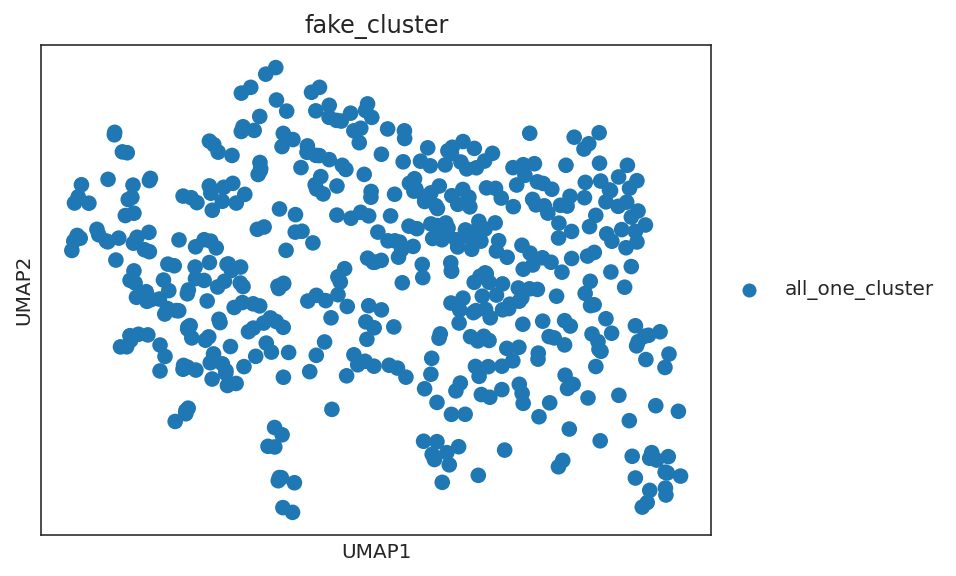

Working on results/baseNetwork_v1/12.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/2298 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2298 genes
Predicting ZNF74
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 ANKRD22 AR AR ARNT2 ARNT2 ASH2L ASH2L ATF2 ATF2 ATF3 ATF3 BACH1 BACH1 BARHL2 BARHL2 BARX2 BARX2 BCL6 BCL6 BHLHE40 BHLHE40 BMP4 BMP4 BRF2 BRF2 CDX2 CDX2 CDX2 CDYL CDYL CEBPB CEBPB CHD4 CHD4 CREB3 CREB3 CTCF DEDD2 DEDD2 DLX2 DLX2 DLX4 DLX4 DMRT1 DMRT1 DMR

In [ ]:
predictions = {
    i: evaluator.trainCausalModelAndPredict(expression=ko_lab_esc_data_train,
                                  baseNetwork=networks[experiments.loc[i,'network']],
                                  memoizationName="results/" + EXPERIMENT_NAME + "/" + str(i) + ".celloracle.oracle", 
                                  perturbations=perturbationsToPredict,
                                  clusterColumnName = "fake_cluster",
                                  pruningParameters = {"p":experiments.loc[i,'p'], 
                                                       "threshold_number":experiments.loc[i,'threshold_number']}) 
    for i in experiments.index
}


In [ ]:
predictions[0]

### Evaluation

We compute the correlation of the predictions with held-out perturbations.

In [ ]:
controlIndex = ko_lab_esc_data_train.obs["perturbation"]=="Control"
evaluator.evaluateCausalModel(heldout = ko_lab_esc_data_heldout, 
                    predictions = predictions,   
                    baseline = ko_lab_esc_data_train[controlIndex,:].X.mean(axis=0), 
                    classifier=cellFateClassifier, 
                    experiments = experiments,
                    factor_varied = "network",
                    experiment_name = EXPERIMENT_NAME)